In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import random
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab
import tensorflow as tf
# import cv2
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
# define the path to the annotation file corresponding to the images you want to work with
dataDir='/Users/kyle/Repositories/coco'
trainData='person_keypoints_train2014'
valData='person_keypoints_val2014'
testData='image_info_test-dev2015'

annTrainFile='{}/annotations/{}.json'.format(dataDir,trainData)
annValFile='{}/annotations/{}.json'.format(dataDir,valData)
annTestFile='{}/annotations/{}.json'.format(dataDir,testData)

imageTrainFolder='{}/images/{}'.format(dataDir,trainData)
imageValFolder='{}/images/{}'.format(dataDir,valData)
imageTestFolder='{}/images/{}'.format(dataDir,testData)

print(annTrainFile)
print(annValFile)
print(annTestFile)
print(imageTrainFolder)
print(imageValFolder)
print(imageTestFolder)

# initialize a coco object
coco = COCO(annTrainFile)

# get all images containing the 'person' category
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds)

catIds = imgIds[0:30]
imgIds = imgIds[0:30]

/Users/kyle/Repositories/coco/annotations/person_keypoints_train2014.json
/Users/kyle/Repositories/coco/annotations/person_keypoints_val2014.json
/Users/kyle/Repositories/coco/annotations/image_info_test-dev2015.json
/Users/kyle/Repositories/coco/images/person_keypoints_train2014
/Users/kyle/Repositories/coco/images/person_keypoints_val2014
/Users/kyle/Repositories/coco/images/image_info_test-dev2015
loading annotations into memory...
Done (t=6.64s)
creating index...
index created!


In [3]:
# Initialize dataset

baseDir = '/Users/kyle/Repositories/coco'
imageTrainDir = 'train2014'
annTrainDir = 'person_keypoints_val2014'
imagePath = '{}/images/{}'.format(baseDir,imageTrainDir)
annPath = '{}/annotations/{}'.format(baseDir,annTrainDir)


filenames = tf.constant(['{}/COCO_train2014_{:0>12}.jpg'.format(imagePath,img_ID) for img_ID in imgIds])
imgID_tensor = tf.constant(imgIds)

precision = tf.float32

In [4]:
def extract_annotations(filename, imgID, coco=coco):
    anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
    ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
    bbox = np.array(np.floor(ann['bbox']),dtype=int)
    keypoints = np.reshape(ann['keypoints'],(-1,3))
    mask = coco.annToMask(ann)
    
    return filename, bbox, keypoints, mask

In [5]:
def resize_image_tf(filename, bbox_tensor, keypoints_tensor, mask, D = tf.constant(224.0)):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=0)
    image = tf.cast(image_decoded, tf.float32)

    mask = tf.transpose([mask],[1,2,0])
    bbox_tensor = tf.to_float(bbox_tensor)
    keypoints_tensor = tf.to_float(keypoints_tensor)

    sideLength = tf.reduce_max(bbox_tensor[2:],axis=0)
    centerX = tf.floor(bbox_tensor[0] + tf.divide(bbox_tensor[2],tf.constant(2.0)))
    centerY = tf.floor(bbox_tensor[1] + tf.divide(bbox_tensor[3],tf.constant(2.0)))
    center = tf.stack([centerX,centerY])

    corner1 = tf.to_int32(tf.minimum(tf.maximum(tf.subtract(center, tf.divide(sideLength,tf.constant(2.0))),0),
                         tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
    corner2 = tf.to_int32(tf.minimum(tf.maximum(tf.add(center, tf.divide(sideLength,tf.constant(2.0))),0),
                         tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
    i_shape = tf.subtract(corner2,corner1)
    d_shape = tf.subtract(tf.to_int32(sideLength),i_shape)

    scale = tf.divide(D, sideLength)

    cropped_image = tf.image.crop_to_bounding_box(image,corner1[1],corner1[0],
                                                  tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])
    cropped_mask = tf.image.crop_to_bounding_box(mask,corner1[1],corner1[0],
                                                  tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])

    dX = tf.floor(tf.divide(d_shape,tf.constant(2)))
    dY = tf.ceil(tf.divide(d_shape,tf.constant(2)))

    pts, labels = tf.split(keypoints_tensor,[2,1],axis=1)
    pts = tf.subtract(pts,tf.to_float(corner1)) # shift keypoints
    pts = tf.add(pts,tf.to_float(dX)) # shift keypoints
    pts = tf.multiply(pts,scale) # scale keypoints
    
    # set invalid pts to 0
    inbounds = tf.less(pts,D)
    inbounds = tf.multiply(tf.to_int32(inbounds), tf.to_int32(tf.greater(pts,0)))
    pts = tf.multiply(pts,tf.to_float(inbounds))

    padded_image = tf.image.pad_to_bounding_box(cropped_image,tf.to_int32(dX[1]),tf.to_int32(dX[0]),
                                                tf.to_int32(sideLength),tf.to_int32(sideLength))
    padded_mask = tf.image.pad_to_bounding_box(cropped_mask,tf.to_int32(dX[1]),tf.to_int32(dX[0]),
                                                tf.to_int32(sideLength),tf.to_int32(sideLength))

    resized_image = tf.image.resize_images(padded_image,tf.constant([224,224]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_mask = tf.image.resize_images(padded_mask,tf.constant([224,224]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return resized_image , resized_mask, pts, labels


In [6]:
myDataset = tf.contrib.data.Dataset.from_tensor_slices((filenames,imgID_tensor))

# Extract Annotations via coco interface
myDataset = myDataset.map(lambda filename, imgID: tf.py_func(extract_annotations, [filename, imgID], 
                                                             [filename.dtype, tf.int64, tf.int64, tf.uint8]))

# All other preprocessing in tensorflow
myDataset = myDataset.map(resize_image_tf)
myDataset

<MapDataset shapes: ((224, 224, ?), (224, 224, ?), <unknown>, <unknown>), types: (tf.float32, tf.uint8, tf.float32, tf.float32)>

In [7]:
# BATCH
myDataset = myDataset.shuffle(buffer_size=10000)
myDataset = myDataset.batch(10) # must resize images to make them match

# iterator = myDataset.make_one_shot_iterator()
# iterator = batched_Dataset.make_one_shot_iterator()
# next_element = iterator.get_next()
# myDataset

iterator = tf.contrib.data.Iterator.from_structure(myDataset.output_types,
                                                   myDataset.output_shapes)
# resized_image, resized_mask, pts, labels = iterator.get_next()
next_element = iterator.get_next()

train_init_op = iterator.make_initializer(myDataset)
myDataset

<BatchDataset shapes: ((?, 224, 224, ?), (?, 224, 224, ?), <unknown>, <unknown>), types: (tf.float32, tf.uint8, tf.float32, tf.float32)>

In [8]:
sess = tf.Session()
sess.run(train_init_op)

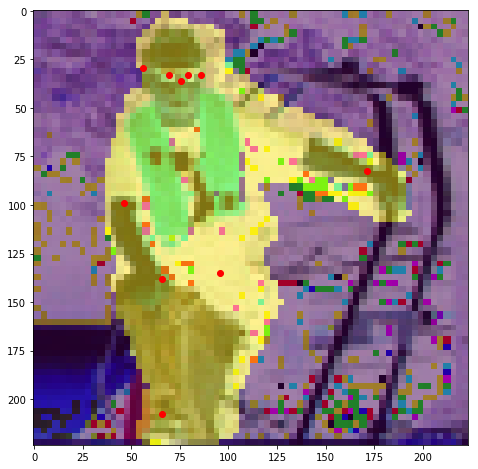

In [9]:
# resized_image, resized_mask, pts, labels = sess.run(next_element)

resized_image, resized_mask, pts, labels = sess.run(next_element)

plt.imshow(resized_image[0])
plt.imshow(resized_mask[0][:,:,0],alpha=0.5)
plt.scatter(pts[0][(np.reshape(labels[0],-1)==2),0],pts[0][(np.reshape(labels[0],-1)==2),1],c="r")

In [ ]:
# sess = tf.InteractiveSession()

In [ ]:
D = tf.constant(224.0)

imgID = imgIds[5]

filename = tf.constant('{}/COCO_train2014_{:0>12}.jpg'.format(imagePath,imgID))
image_string = tf.read_file(filename)
image_decoded = tf.image.decode_jpeg(image_string, channels=0)          # (1)
image = tf.cast(image_decoded, tf.float32)

# npimage = image.eval()

anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
mask = tf.constant(coco.annToMask(ann))
mask = tf.transpose([mask],[1,2,0])

bbox_tensor = tf.constant(np.array(np.floor(ann['bbox'])),dtype=tf.float32)
keypoints_tensor = tf.constant(np.reshape(ann['keypoints'],(-1,3)),dtype=tf.float32)

sideLength = tf.reduce_max(bbox_tensor[2:],axis=0)
centerX = tf.floor(bbox_tensor[0] + tf.divide(bbox_tensor[2],2.0))
centerY = tf.floor(bbox_tensor[1] + tf.divide(bbox_tensor[3],2.0))
center = tf.stack([centerX,centerY])

corner1 = tf.to_int32(tf.minimum(tf.maximum(tf.subtract(center,tf.divide(sideLength,2.0)),0),
                     tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
corner2 = tf.to_int32(tf.minimum(tf.maximum(tf.add(center,tf.divide(sideLength,2.0)),0),
                     tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
i_shape = tf.subtract(corner2,corner1)
d_shape = tf.subtract(tf.to_int32(sideLength),i_shape)

scale = tf.divide(D, sideLength)

cropped_image = tf.image.crop_to_bounding_box(image,corner1[1],corner1[0],
                                              tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])
cropped_mask = tf.image.crop_to_bounding_box(mask,corner1[1],corner1[0],
                                              tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])

# dX = np.floor(d_shape/2.0).astype(int)
dX = tf.floor(tf.divide(d_shape,tf.constant(2)))
dY = tf.ceil(tf.divide(d_shape,tf.constant(2)))

# inbounds = (keypoints[:,0] >= 0)*(keypoints[:,0] <= sideLength)*(keypoints[:,1] >= 0)*(keypoints[:,1] <= sideLength)
pts, labels = tf.split(keypoints_tensor,[2,1],axis=1)
pts = tf.subtract(pts,tf.to_float(corner1)) # shift keypoints
pts = tf.multiply(pts,scale) # scale keypoints
inbounds = tf.less(pts,D)
inbounds = tf.multiply(tf.to_int32(inbounds), tf.to_int32(tf.greater(pts,0)))
pts = tf.multiply(pts,tf.to_float(inbounds))

padded_image = tf.image.pad_to_bounding_box(cropped_image,tf.to_int32(dX[1]),tf.to_int32(dX[0]),
                                            tf.to_int32(sideLength),tf.to_int32(sideLength))
padded_mask = tf.image.pad_to_bounding_box(cropped_mask,tf.to_int32(dX[1]),tf.to_int32(dX[0]),
                                            tf.to_int32(sideLength),tf.to_int32(sideLength))

resized_image = tf.image.resize_images(padded_image,tf.constant([224,224]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
resized_mask = tf.image.resize_images(padded_mask,tf.constant([224,224]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)


kpts = pts.eval()
labels = labels.eval()
I = resized_image.eval()
mask = resized_mask.eval()
plt.imshow(I)
plt.imshow(mask[:,:,0],alpha=0.25)
plt.scatter(kpts[(np.reshape(labels,-1)==2),0],pts.eval()[(np.reshape(labels,-1)==2),1],c="r")


In [ ]:
def extract_square_image(image, imgID, coco=coco, D=224.0):
    anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
    ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
    bbox = np.array(np.floor(ann['bbox']),dtype=int)
    mask = coco.annToMask(ann)

    sideLength = np.max(bbox[2:]) # largest side
    center = (np.floor(bbox[0]+bbox[2]/2.0), np.floor(bbox[1]+bbox[3]/2.0))
    corner1 = np.minimum(np.maximum(np.array(center - sideLength/2.0,dtype=int), 0), np.flip(image.shape[:2],axis=0))
    corner2 = np.minimum(np.maximum(np.array(center + sideLength/2.0,dtype=int), 0), np.flip(image.shape[:2],axis=0))
    i_shape = corner2 - corner1
    d_shape = sideLength - i_shape
    scale = np.array(D/sideLength, dtype=float)
    
    cropped_image = image[corner1[1]:corner2[1], corner1[0]:corner2[0],:]
    cropped_mask = mask[corner1[1]:corner2[1], corner1[0]:corner2[0]]
    
    dX = np.floor(d_shape/2.0).astype(int)
    dY = np.ceil(d_shape/2.0).astype(int)
    keypoints = np.reshape(ann['keypoints'],(-1,3)) - np.array([corner1[0]-dX[0],corner1[1]-dX[1],0])
    inbounds = (keypoints[:,0] >= 0)*(keypoints[:,0] <= sideLength)*(keypoints[:,1] >= 0)*(keypoints[:,1] <= sideLength)
    keypoints[inbounds == 0,2] = 2
    keypoints[inbounds == 0,0] = 0
    keypoints[inbounds == 0,1] = 0
    
    padded_image = np.dstack([np.lib.pad(
                cropped_image[:,:,i],((dX[1],dY[1]),
                                      (dX[0],dY[0])),mode='constant') for i in range(3)])
    padded_mask = np.lib.pad(cropped_mask,((dX[1],dY[1]),(dX[0],dY[0])),mode='constant')

    return padded_image, padded_mask, keypoints, scale

In [ ]:
def resize_image(image, mask, keypoints, scale, D=224.0):
    resized_image = tf.image.resize_images(image, [D, D],tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_mask = tf.image.resize_images(mask, [D, D],tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    pts, labels = tf.split(keypoints_tensor,[2,1],axis=2)
    pts = tf.multiply(pts,scale)
    resized_keypoints = tf.concat([pts,labels],axis=2)
    
    return resized_image, resized_mask, resized_keypoints
    
    

In [ ]:
# def getImageTraining(filename, imgID, smallest_side=224.0):
def getImageTraining(filename, bbox_tensor, keypoints_tensor, crowd_tensor, 
                     area_tensor, mask_tensor, smallest_side=224.0):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=0)          # (1)
#     image = tf.cast(image_decoded, tf.float32)
    image = image_decoded

    smallest_side = 224.0
    height, width = tf.shape(image)[0], tf.shape(image)[1]
    height = tf.to_float(height)
    width = tf.to_float(width)

    scale = tf.cond(tf.greater(height, width),
                    lambda: smallest_side / width,
                    lambda: smallest_side / height)
    new_height = tf.maximum(tf.to_int32(height * scale), tf.to_int32(smallest_side))
    new_width = tf.maximum(tf.to_int32(width * scale), tf.to_int32(smallest_side))

    resized_image = tf.image.resize_images(image, [new_height, new_width],tf.image.ResizeMethod.NEAREST_NEIGHBOR)  # (2)
    
    # resize label tensors:
    bbox_tensor = tf.multiply(bbox_tensor,scale)
    pts, labels = tf.split(keypoints_tensor,[2,1],axis=2)
    pts = tf.multiply(pts,scale)
    keypoints_tensor = tf.concat([pts,labels],axis=2)
    area_tensor = area_tensor*scale*scale
    mask_tensor = tf.transpose(mask_tensor,[1,2,3,0])
    mask_tensor = tf.image.resize_images(mask_tensor, [new_height, new_width],tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return resized_image, bbox_tensor, keypoints_tensor, crowd_tensor, area_tensor, mask_tensor

In [ ]:
# load and display image
# img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0] # select a random image
img = coco.loadImgs(imgIds[2])[0] # select a random image
anns = coco.loadAnns(coco.getAnnIds(img['id'],catIds=[1],iscrowd=None))
ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
bbox = np.array(np.floor(ann['bbox']),dtype=int)
mask = coco.annToMask(ann)

image = io.imread('http://mscoco.org/images/%d'%(img['id'])) # use url to load image
padded_image, cropped_image, keypoints, mask, cropped_mask, padded_mask, scale = crop_to_largest_instance(image,img['id'])

# Display image
visualizeProcessedImage(image, cropped_image, padded_image, mask, cropped_mask, padded_mask, ann, keypoints, scale)

In [ ]:
def crop_to_largest_instance(image, imgID, coco=coco, D=224.0):
    anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
    ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
    bbox = np.array(np.floor(ann['bbox']),dtype=int)
    mask = coco.annToMask(ann)

    sideLength = np.max(bbox[2:]) # largest side
    center = (np.floor(bbox[0]+bbox[2]/2.0), np.floor(bbox[1]+bbox[3]/2.0))
    corner1 = np.minimum(np.maximum(np.array(center - sideLength/2.0,dtype=int), 0), np.flip(image.shape[:2],axis=0))
    corner2 = np.minimum(np.maximum(np.array(center + sideLength/2.0,dtype=int), 0), np.flip(image.shape[:2],axis=0))
    i_shape = corner2 - corner1
    d_shape = sideLength - i_shape
    scale = np.array(D/sideLength)
    
    cropped_image = image[corner1[1]:corner2[1], corner1[0]:corner2[0],:]
    cropped_mask = mask[corner1[1]:corner2[1], corner1[0]:corner2[0]]
    
    dX = np.floor(d_shape/2.0).astype(int)
    dY = np.ceil(d_shape/2.0).astype(int)
    keypoints = np.reshape(ann['keypoints'],(-1,3)) - np.array([corner1[0]-dX[0],corner1[1]-dX[1],0])
    inbounds = (keypoints[:,0] >= 0)*(keypoints[:,0] <= sideLength)*(keypoints[:,1] >= 0)*(keypoints[:,1] <= sideLength)
    keypoints[inbounds == 0,2] = 2
    keypoints[inbounds == 0,0] = 0
    keypoints[inbounds == 0,1] = 0
    
    padded_image = np.dstack([np.lib.pad(
                cropped_image[:,:,i],((dX[1],dY[1]),
                                      (dX[0],dY[0])),mode='constant') for i in range(3)])
    padded_mask = np.lib.pad(cropped_mask,((dX[1],dY[1]),(dX[0],dY[0])),mode='constant')

    return padded_image, cropped_image, keypoints, mask, cropped_mask, padded_mask, scale

In [ ]:
def visualizeProcessedImage(image, cropped_image, padded_image, mask, cropped_mask, padded_mask, ann, keypoints, scale):
    plt.figure(figsize=[16,10])
    ax = plt.subplot(2,3,1)
    ax.imshow(image)
    bbox = ann['bbox']
    ax.add_patch(patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],fill=False,edgecolor="orange"))

    plt.subplot(2,3,2)
    plt.imshow(cropped_image)

    plt.subplot(2,3,3)
    plt.imshow(padded_image)

    plt.subplot(2,3,4)
    plt.imshow(mask,alpha=.5)
    
    plt.subplot(2,3,5)
    plt.imshow(cropped_mask)
    
    plt.subplot(2,3,6)
    plt.imshow(padded_image)
    plt.imshow(padded_mask,alpha=.5)
    plt.scatter(keypoints[:,0],keypoints[:,1],c="r")

In [ ]:
def load_image(filename, imgID):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=0)          # (1)
    image = tf.cast(image_decoded, tf.float32)
    
    return image, imgID